In [ ]:
import os

import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from skimage import color
from typing import Optional, Dict
import yaml



In [ ]:
data_path="..data/"

# Setup Datasets, Dataloaders and Augmentations/Transforms

In [ ]:
class RemoveDarkLines:
    def __init__(self, threshold=10):
        """
        threshold: Pixel value below which is considered dark.
        """
        self.threshold = threshold

    def __call__(self, image):
        # Convert PIL image to OpenCV format
        image_np = np.array(image)

        # Convert to grayscale
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

        # Identify dark rows and columns
        dark_rows = np.all(gray < self.threshold, axis=1)
        dark_cols = np.all(gray < self.threshold, axis=0)

        # Remove those rows and columns
        image_np = image_np[~dark_rows]
        image_np = image_np[:, ~dark_cols]

        # Convert back to PIL format
        return image_np


In [ ]:
class OvarianCancerDataset(Dataset):
    def __init__(self, image_ids, labels, img_folder, thumbnail_folder, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.img_folder = img_folder
        self.thumbnail_folder = thumbnail_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # Check if thumbnail exists
        thumbnail_path = os.path.join(self.thumbnail_folder, str(img_id) + "_thumbnail" + ".png")
        if os.path.exists(thumbnail_path):
            img = Image.open(thumbnail_path)
        else:
            img_path = os.path.join(self.img_folder, str(img_id) + ".png")
            img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]

        return img, label

In [ ]:
# Loading data from CSV
df = pd.read_csv(data_path+'train.csv')
image_ids = df['image_id'].tolist()

# Encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'].tolist())

# Combining label and is_tma for stratification
stratify_column = df['is_tma'].astype(str) + "_" + df['label']
is_tma_list = df['is_tma'].tolist()

# Stratified split based on the combined stratify_column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(image_ids, stratify_column):
    train_image_ids = [image_ids[i] for i in train_idx]
    val_image_ids = [image_ids[i] for i in val_idx]
    train_labels = [encoded_labels[i] for i in train_idx]
    val_labels = [encoded_labels[i] for i in val_idx]

In [ ]:
def compute_dataset_mean_std(dataset):
    to_tensor = transforms.ToTensor()  # Transformation to convert PIL Image to Tensor
    means = []
    stds = []
    for idx in range(len(dataset)):
        image, _ = dataset[idx]  # Get image. We don't need the label for this task.
        means.append(torch.mean(image.view(3, -1), dim=1))  # Calculating mean across height and width
        stds.append(torch.std(image.view(3, -1), dim=1))    # Calculating std across height and width

    # Compute the global mean and std
    mean = torch.stack(means, dim=0).mean(dim=0)
    std = torch.sqrt(torch.stack(stds, dim=0).var(dim=0))  # Correctly calculating std

    return mean, std

train_dataset = OvarianCancerDataset(train_image_ids, train_labels, data_path+'train_images', data_path+'train_thumbnails', mean_std_calc_transform)
mean_std_calc_transform = transforms.Compose([
    RemoveDarkLines(threshold=5),
    transforms.ToTensor(),
])


mean, std = compute_dataset_mean_std(train_dataset)
print("Mean:", mean)
print("Std:", std)

In [ ]:
class Dict2Class(object):
    # ToDo: Wrap into RandStainNA
    def __init__(self, my_dict: Dict):
        self.my_dict = my_dict
        for key in my_dict:
            setattr(self, key, my_dict[key])

class RandStainNA(object):
    def __init__(
        self,
        yaml_file: str,
        std_hyper: Optional[float] = 0,
        distribution: Optional[str] = "normal",
        probability: Optional[float] = 1.0,
        is_train: Optional[bool] = True,
    ):
        assert distribution in [
            "normal",
            "laplace",
            "uniform",
        ], "Unsupported distribution style {}.".format(distribution)

        self.yaml_file = yaml_file
        cfg = self._get_yaml_data(self.yaml_file)
        c_s = cfg["color_space"]

        self._channel_avgs = {
            "avg": [
                cfg[c_s[0]]["avg"]["mean"],
                cfg[c_s[1]]["avg"]["mean"],
                cfg[c_s[2]]["avg"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["avg"]["std"],
                cfg[c_s[1]]["avg"]["std"],
                cfg[c_s[2]]["avg"]["std"],
            ],
        }

        self._channel_stds = {
            "avg": [
                cfg[c_s[0]]["std"]["mean"],
                cfg[c_s[1]]["std"]["mean"],
                cfg[c_s[2]]["std"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["std"]["std"],
                cfg[c_s[1]]["std"]["std"],
                cfg[c_s[2]]["std"]["std"],
            ],
        }

        self.channel_avgs = Dict2Class(self._channel_avgs)
        self.channel_stds = Dict2Class(self._channel_stds)

        self.p = probability
        self.std_adjust = std_hyper
        self.color_space = c_s
        self.distribution = distribution
        self.is_train = is_train

    def _get_yaml_data(self, yaml_file):
        with open(yaml_file, "r", encoding="utf-8") as file:
            data = yaml.load(file, Loader=yaml.FullLoader)
        return data

    def _create_mask(self, image: np.ndarray, threshold: int = 5) -> np.ndarray:
      """Create a binary mask separating the tissue from the background."""
      grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      _, binary_mask = cv2.threshold(grayscale, threshold, 1, cv2.THRESH_BINARY)
      return binary_mask

    def _getavgstd(self, image: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        avgs = [np.sum(image[:, :, idx] * mask) / np.sum(mask) for idx in range(image.shape[2])]
        masked_image = np.repeat(mask[:, :, np.newaxis], 3, axis=2) * image
        stds = [np.std(masked_image[:, :, idx]) for idx in range(image.shape[2])]
        return np.array(avgs), np.array(stds)

    def _normalize(
        self,
        img: np.ndarray,
        img_avgs: np.ndarray,
        img_stds: np.ndarray,
        tar_avgs: np.ndarray,
        tar_stds: np.ndarray,
    ) -> np.ndarray:

        img_stds = np.clip(img_stds, 0.0001, 255)
        img = (img - img_avgs) * (tar_stds / img_stds) + tar_avgs

        if self.color_space in ["LAB", "HSV"]:
            img = np.clip(img, 0, 255).astype(np.uint8)

        return img

    def _apply_masked_transform(self, image: np.ndarray, mask: np.ndarray, transformed: np.ndarray) -> np.ndarray:
        """Apply the transformation only to the masked region."""
        expanded_mask = np.expand_dims(mask, axis=-1)  # Shape becomes [height, width, 1]
        return image * (1 - expanded_mask) + transformed * expanded_mask


    def augment(self, img):
        # img:is_train:false——>np.array()(cv2.imread()) #BGR
        # img:is_train:True——>PIL.Image #RGB

        if self.is_train == False:
            image = img
        else:
            image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        mask = self._create_mask(image)

        num_of_channel = image.shape[2]

        # color space transfer
        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.color_space == "HED":
            image = color.rgb2hed(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        std_adjust = self.std_adjust

        # virtual template generation
        tar_avgs = []
        tar_stds = []
        if self.distribution == "uniform":

            # three-sigma rule for uniform distribution
            for idx in range(num_of_channel):

                tar_avg = np.random.uniform(
                    low=self.channel_avgs.avg[idx] - 3 * self.channel_avgs.std[idx],
                    high=self.channel_avgs.avg[idx] + 3 * self.channel_avgs.std[idx],
                )
                tar_std = np.random.uniform(
                    low=self.channel_stds.avg[idx] - 3 * self.channel_stds.std[idx],
                    high=self.channel_stds.avg[idx] + 3 * self.channel_stds.std[idx],
                )

                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)
        else:
            if self.distribution == "normal":
                np_distribution = np.random.normal
            elif self.distribution == "laplace":
                np_distribution = np.random.laplace

            for idx in range(num_of_channel):
                tar_avg = np_distribution(
                    loc=self.channel_avgs.avg[idx],
                    scale=self.channel_avgs.std[idx] * (1 + std_adjust),
                )

                tar_std = np_distribution(
                    loc=self.channel_stds.avg[idx],
                    scale=self.channel_stds.std[idx] * (1 + std_adjust),
                )
                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)

        tar_avgs = np.array(tar_avgs)
        tar_stds = np.array(tar_stds)

        img_avgs, img_stds = self._getavgstd(image, mask)

        transformed_image = self._normalize(
            img=image,
            img_avgs=img_avgs,
            img_stds=img_stds,
            tar_avgs=tar_avgs,
            tar_stds=tar_stds,
        )

        # Now, apply transformation only to tissue regions, keep the black background unchanged
        transformed_image = self._apply_masked_transform(image, mask, transformed_image)

        if self.color_space == "LAB":
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_LAB2RGB)
        elif self.color_space == "HSV":
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_HSV2BGR)
        elif self.color_space == "HED":
            nimg = color.hed2rgb(transformed_image)
            imin = nimg.min()
            imax = nimg.max()
            rsimg = (255 * (nimg - imin) / (imax - imin)).astype("uint8")  # rescale to [0,255]
            transformed_image = cv2.cvtColor(rsimg, cv2.COLOR_RGB2BGR)

        return transformed_image

    def __call__(self, img):
        if np.random.rand(1) < self.p:
            return self.augment(img)
        else:
            return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += f"methods=Reinhard"
        format_string += f", colorspace={self.color_space}"
        format_string += f", mean={self._channel_avgs}"
        format_string += f", std={self._channel_stds}"
        format_string += f", std_adjust={self.std_adjust}"
        format_string += f", distribution={self.distribution}"
        format_string += f", p={self.p})"
        return format_string

In [ ]:
class ProbabilisticTransform:
    def __init__(self, transform, probability):
        self.transform = transform
        self.probability = probability

    def __call__(self, img):
        if np.random.rand() < self.probability:
            return self.transform(img)
        return img


In [ ]:
mean = torch.Tensor([0.5443, 0.4728, 0.5404]) # Calculated from trainset
std = torch.Tensor([0.0585, 0.0377, 0.0545]) # Calculated from trainset
resize_dim = (224, 224) 

train_transform = transforms.Compose([
    RemoveDarkLines(threshold=5),
    RandStainNA(yaml_file='./CRC_LAB_randomTrue_n0.yaml', std_hyper=-0.3, probability=0.9, distribution='normal', is_train=True),
    lambda x: Image.fromarray(x),
    ProbabilisticTransform(transforms.RandomRotation(20), 0.2),
    ProbabilisticTransform(transforms.RandomResizedCrop(size=resize_dim, scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2), 0.2),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    ProbabilisticTransform(transforms.ElasticTransform(alpha=50.0, sigma=5.0, interpolation=transforms.InterpolationMode.BILINEAR, fill=0), 0.3),
    ProbabilisticTransform(transforms.GaussianBlur(kernel_size=int(0.1 * resize_dim[0]+1)), 0.05),
    transforms.Resize(resize_dim),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    RemoveDarkLines(threshold=5),
    lambda x: Image.fromarray(x),
    transforms.Resize(resize_dim),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = OvarianCancerDataset(train_image_ids, train_labels, data_path+'train_images', data_path+'train_thumbnails', train_transform)
val_dataset = OvarianCancerDataset(val_image_ids, val_labels, data_path+'train_images', data_path+'train_thumbnails', val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Instpect Dataset Distribution and Visualize

In [ ]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def inspect_dataset(df, train_image_ids, val_image_ids):
    # Distributions
    train_tma_dist = df[df['image_id'].isin(train_image_ids)]['is_tma'].value_counts()
    val_tma_dist = df[df['image_id'].isin(val_image_ids)]['is_tma'].value_counts()

    train_label_dist = df[df['image_id'].isin(train_image_ids)]['label'].value_counts()
    val_label_dist = df[df['image_id'].isin(val_image_ids)]['label'].value_counts()

    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    bar_width = 0.4  # Adjust this value as needed

    axs[0, 0].bar(train_tma_dist.index, train_tma_dist.values, width=bar_width, color='blue', alpha=0.7, label='Train')
    axs[0, 0].set_title('TMA distribution in Train set')

    axs[0, 1].bar(val_tma_dist.index, val_tma_dist.values, width=bar_width, color='red', alpha=0.7, label='Validation')
    axs[0, 1].set_title('TMA distribution in Validation set')

    axs[1, 0].bar(train_label_dist.index, train_label_dist.values, width=bar_width, color='blue', alpha=0.7, label='Train')
    axs[1, 0].set_title('Label distribution in Train set')

    axs[1, 1].bar(val_label_dist.index, val_label_dist.values, width=bar_width, color='red', alpha=0.7, label='Validation')
    axs[1, 1].set_title('Label distribution in Validation set')

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

In [ ]:
def display_images(dataset_1, dataset_2, label_encoder, num_imgs=4, shuffle=False):
    # Randomly sample and plot num_imgs images from train and validation
    fig, axs = plt.subplots(2, num_imgs, figsize=(36, 20))

    # Training images
    for ax, (imgs, labels) in zip(axs[0], DataLoader(dataset_1, batch_size=num_imgs, shuffle=False)):
        for i in range(imgs.shape[0]):
            img = denormalize(imgs[i], mean, std)  # Denormalize
            #img = imgs[i]
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            ax.set_title(label_encoder.inverse_transform([labels[i].item()])[0])
            ax.axis('on')

    # Validation images
    for ax, (imgs, labels) in zip(axs[1], DataLoader(dataset_2, batch_size=num_imgs, shuffle=False)):
        for i in range(imgs.shape[0]):
            img = denormalize(imgs[i], mean, std)  # Denormalize
            #img = imgs[i]
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            ax.set_title(label_encoder.inverse_transform([labels[i].item()])[0])
            ax.axis('on')

    plt.tight_layout()
    plt.show()

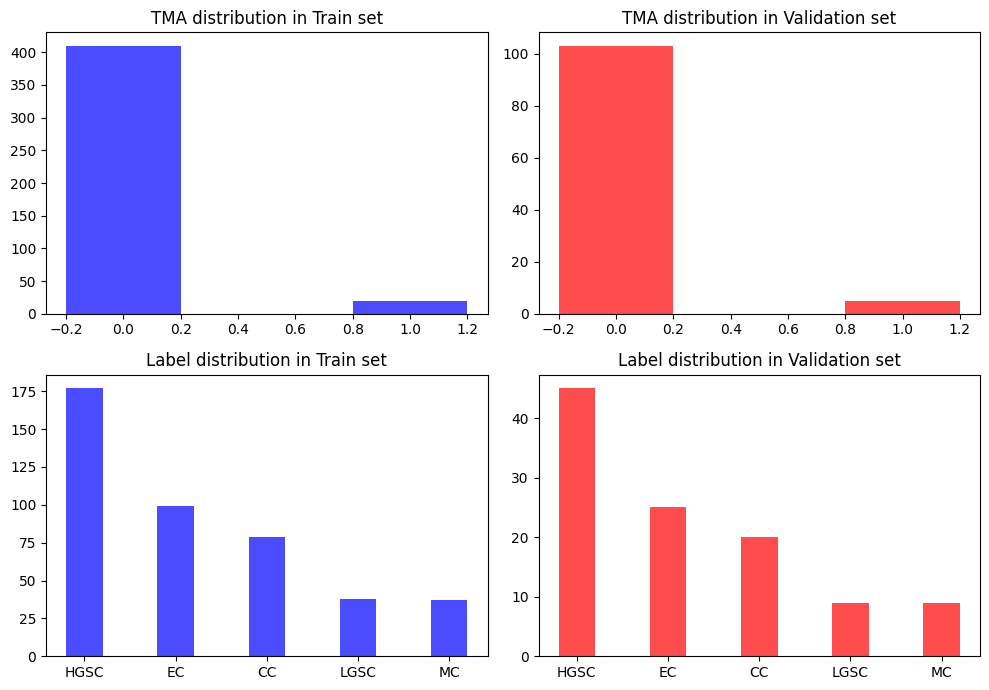

<Figure size 640x480 with 0 Axes>

In [ ]:
# Call the function
inspect_dataset(df, train_image_ids, val_image_ids)

In [ ]:
display_dataset1 = OvarianCancerDataset(train_image_ids, train_labels, data_path+'train_images', data_path+'train_thumbnails', train_transform)
display_dataset2 = OvarianCancerDataset(train_image_ids, train_labels, data_path+'train_images', data_path+'train_thumbnails', val_transform)
display_images(display_dataset1, display_dataset2, label_encoder, num_imgs=4, shuffle=False)

In [ ]:
display_images(display_dataset1, display_dataset2, label_encoder, num_imgs=4, shuffle=False)

In [ ]:
display_images(display_dataset1, display_dataset2, label_encoder, num_imgs=4, shuffle=False)

# Setup Metric and Loss

In [ ]:
# class dsitributions
train_tma_dist = df[df['image_id'].isin(train_image_ids)]['is_tma'].value_counts()
val_tma_dist = df[df['image_id'].isin(val_image_ids)]['is_tma'].value_counts()

train_label_dist = df[df['image_id'].isin(train_image_ids)]['label'].value_counts()
val_label_dist = df[df['image_id'].isin(val_image_ids)]['label'].value_counts()


# compute class weights
train_class_weights = 1.0 / train_label_dist
val_class_weights = 1.0 / val_label_dist
train_class_weights = torch.tensor(train_class_weights / train_class_weights.sum()).float()
val_class_weights = torch.tensor(val_class_weights / val_class_weights.sum()).float()
print(train_class_weights)
print(val_class_weights)
print(train_class_weights.sum())

tensor([0.0691, 0.1236, 0.1548, 0.3219, 0.3306])
tensor([0.0664, 0.1196, 0.1495, 0.3322, 0.3322])
tensor(1.)


In [ ]:
def balanced_accuracy(y, preds, weights=None):
    """
    Calculates the balanced accuracy given true labels (y), predictions (preds), and optional weights.

    :param y: True labels
    :param preds: Predicted labels
    :param weights: Optional weights for each class
    :return: balanced accuracy
    """

    y = y.cpu()
    preds = preds.cpu()

    # Extract unique classes present in this batch
    unique_classes = torch.unique(y).cpu().numpy()

    recalls = []
    for cls in unique_classes:
        cls_mask = (y == cls)
        tp = torch.sum((preds[cls_mask] == cls).float())
        fn = torch.sum((preds[cls_mask] != cls).float())
        recall = tp / (tp + fn)
        recalls.append(recall)

    if weights is not None:
        weights = weights.cpu()
        selected_weights = weights[unique_classes]
        weighted_avg = torch.sum(torch.tensor(recalls) * selected_weights) / torch.sum(selected_weights)
        return weighted_avg

    return torch.mean(torch.tensor(recalls))

In [ ]:
# Modified slightly from arkrde's implementation : https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/15
class FocalLoss(nn.Module):

    def __init__(self, config):
        nn.Module.__init__(self)
        self.weight = config["weight"]
        self.gamma = config["gamma"]
        self.reduction = config["reduction"]

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction = self.reduction
        )

# Setup Model

In [ ]:
class PretrainedConvNeXt(nn.Module):
    def __init__(self, config):
        super(PretrainedConvNeXt, self).__init__()

        self.num_classes = config["num_classes"]
        self.freeze_pretrained = config["freeze_pretrained"]

        self.model = models.convnext_small(pretrained=True)

        # Optionally freeze the pre-trained layers
        if self.freeze_pretrained:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace the classifier layer
        self.model.classifier[2] = nn.Linear(768, self.num_classes)

    def forward(self, x):
        return self.model(x)



In [ ]:
class Classifier(pl.LightningModule):
    def __init__(self, config, train_class_weights, val_class_weights):
        super(Classifier, self).__init__()

        self.lr = config["lr"]
        model_name = config["model_name"]

        # Store class weights
        self.train_class_weights = train_class_weights
        self.val_class_weights = val_class_weights

        if model_name == 'ConvNext':
            self.model = PretrainedConvNeXt(config)
        else:
            raise ValueError(f"Model name {model_name} not recognized")


        self.criterion = FocalLoss(config)

    def forward(self, x):
        return self.model(x)

    def on_train_start(self):
        self.train_class_weights = self.train_class_weights.to(self.device)

    def on_validation_start(self):
        self.val_class_weights = self.val_class_weights.to(self.device)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)

        weighted_acc = balanced_accuracy(y, preds, self.train_class_weights)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_weighted_accuracy', weighted_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)

        weighted_acc = balanced_accuracy(y, preds, self.val_class_weights)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_weighted_accuracy', weighted_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
      # Set the learning rate for the pre-trained layers to be 100 times smaller
      pre_trained_lr = self.lr / 100

      # Separate the parameters of the pre-trained model and the newly added final layer
      pre_trained_params = []
      final_layer_params = []
      for name, param in self.model.named_parameters():
          if name.startswith('model.classifier'):
              final_layer_params.append(param)
          else:
              pre_trained_params.append(param)

      # Create two parameter groups with different learning rates
      optimizer_groups = [
          {'params': pre_trained_params, 'lr': pre_trained_lr},
          {'params': final_layer_params, 'lr': self.lr}
      ]

      # Initialize the optimizer with these parameter groups
      return torch.optim.Adam(optimizer_groups, lr=self.lr)


# Setup Training and Train

In [ ]:
device = torch.device("cuda")
config = {
    "lr": 0.001,
    "model_name": "ConvNext",
    "num_classes": 5,
    "weight": train_class_weights.to(device),
    "gamma": 2,
    "reduction": "mean",
    "freeze_pretrained": False
}


model = Classifier(config, train_class_weights, val_class_weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:05<00:00, 39.7MB/s]


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/models",
    filename="baseline-best-checkpoint-new",
    save_top_k=1,
    verbose=True,
    monitor="val_weighted_accuracy",
    mode="max"
)

In [ ]:
wandb_logger = WandbLogger(name="baseline", project="DL-2023")

In [ ]:
trainer = Trainer(max_epochs=15, logger=wandb_logger, log_every_n_steps=5, callbacks=[checkpoint_callback],)
trainer.fit(model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jonasgg (gggggggggggg). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PretrainedConvNeXt | 49.5 M
1 | criterion | FocalLoss          | 0     
-------------------------------------------------
49.5 M    Trainable params
0         Non-trainable params
49.5 M    Total params
197.834   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 54: 'val_weighted_accuracy' reached 0.32490 (best 0.32490), saving model to '/content/drive/MyDrive/models/baseline-best-checkpoint-new.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 108: 'val_weighted_accuracy' reached 0.50455 (best 0.50455), saving model to '/content/drive/MyDrive/models/baseline-best-checkpoint-new.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 162: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 216: 'val_weighted_accuracy' reached 0.50807 (best 0.50807), saving model to '/content/drive/MyDrive/models/baseline-best-checkpoint-new.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 270: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 324: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 378: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 432: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 486: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 540: 'val_weighted_accuracy' reached 0.60548 (best 0.60548), saving model to '/content/drive/MyDrive/models/baseline-best-checkpoint-new.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 594: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 648: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 702: 'val_weighted_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 756: 'val_weighted_accuracy' reached 0.62886 (best 0.62886), saving model to '/content/drive/MyDrive/models/baseline-best-checkpoint-new.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 810: 'val_weighted_accuracy' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
